In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.sparse import coo_matrix
from numba import jit, prange

# Prepare data

## Sparse matrix

In [2]:
ds = xr.open_dataset("weights.nc")
ds

<xarray.Dataset>
Dimensions:  (n_s: 480000)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 ...
    col      (n_s) int32 ...
    row      (n_s) int32 ...

In [3]:
n_s = ds.dims['n_s']
col = ds['col'].values - 1
row = ds['row'].values - 1
S = ds['S'].values

In [4]:
A = coo_matrix((S, (row, col))) 
A.shape

(120000, 240000)

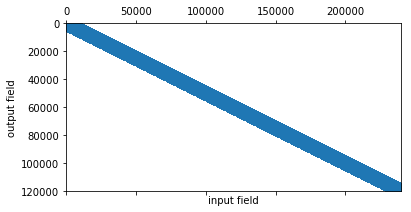

In [5]:
plt.spy(A)
plt.xlabel('input field')
plt.ylabel('output field')

## Input data

In [6]:
data = np.random.rand(500, A.shape[1])
data.shape

(500, 240000)

# scipy.sparse dot


## Common memory order

In [7]:
A_csc = A.tocsc()
A_csr = A.tocsr()

In [8]:
%timeit A.dot(data.T).T
%timeit A_csc.dot(data.T).T
%timeit A_csr.dot(data.T).T

534 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.04 s ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.04 s ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
data.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

## Reversed memory order

In [10]:
data_T = data.T.copy()

In [11]:
data_T.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [12]:
%timeit A.dot(data_T).T
%timeit A_csc.dot(data_T).T
%timeit A_csr.dot(data_T).T

3.26 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
343 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
365 ms ± 8.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# numba

In [13]:
data_out = np.zeros([data.shape[0], A.shape[1]])
data_out.shape

(500, 240000)

In [14]:
@jit(nopython=True)
def sparse_dot(data_out, data, col, row, S):
    data_out[...] = 0.0
    for j in range(data.shape[0]):
        for i in range(S.size):
            data_out[j, row[i]] += data[j, col[i]]*S[i]
    return data_out

sparse_dot(data_out, data, col, row, S); # compile jit

In [15]:
%timeit sparse_dot(data_out, data, col, row, S)

478 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Numba parallel

In [16]:
@jit(parallel=True)
def sparse_dot_parallel(data_out, data, col, row, S):
    data_out[...] = 0.0
    for j in prange(data.shape[0]):
        for i in range(S.size):
            data_out[j, row[i]] += data[j, col[i]]*S[i]
    return data_out

sparse_dot_parallel(data_out, data, col, row, S); # compile jit

In [17]:
%timeit sparse_dot_parallel(data_out, data, col, row, S)

229 ms ± 6.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
